# Classic ML Models

In [1]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install idx2numpy --quiet
!pip install tensorflow --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
import os
import requests
import zipfile
import gzip
import shutil
import idx2numpy
import numpy as np

dataset_dir = "/content/EMNIST"
os.makedirs(dataset_dir, exist_ok=True)

zip_path = os.path.join(dataset_dir, "gzip.zip")

# Download the EMNIST dataset zip if not present
if not os.path.exists(zip_path):
    print("Downloading EMNIST dataset...")
    url = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
    response = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(response.content)
    print("Download complete!")

# Extract the main zip
gzip_dir = os.path.join(dataset_dir, "gzip")
if not os.path.exists(gzip_dir):
    print("Extracting gzip.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(gzip_dir)
    print("Extraction complete!")

# Recursively decompress all .gz files
for root, dirs, files in os.walk(gzip_dir):
    for file in files:
        if file.endswith(".gz"):
            gz_path = os.path.join(root, file)
            out_path = os.path.join(root, file[:-3])
            if not os.path.exists(out_path):
                print(f"Decompressing {gz_path} ...")
                with gzip.open(gz_path, 'rb') as f_in:
                    with open(out_path, 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
print("All .gz files decompressed!")

In [ ]:
import idx2numpy
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Paths
train_images_path = os.path.join(gzip_dir, "gzip/emnist-balanced-train-images-idx3-ubyte")
train_labels_path = os.path.join(gzip_dir, "gzip/emnist-balanced-train-labels-idx1-ubyte")
test_images_path  = os.path.join(gzip_dir, "gzip/emnist-balanced-test-images-idx3-ubyte")
test_labels_path  = os.path.join(gzip_dir, "gzip/emnist-balanced-test-labels-idx1-ubyte")
balanced_mapping_path = os.path.join(gzip_dir, "gzip/emnist-balanced-mapping.txt")
# train_images_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-train-images-idx3-ubyte"
# train_labels_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-train-labels-idx1-ubyte"
# test_images_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-test-images-idx3-ubyte"
# test_labels_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-test-labels-idx1-ubyte"
# balanced_mapping_path = r"/content/drive/MyDrive/ML_project/gzip/emnist-balanced-mapping.txt"
# train_images_path = r"gzip/emnist-balanced-train-images-idx3-ubyte"
# train_labels_path = r"gzip/emnist-balanced-train-labels-idx1-ubyte"
# test_images_path = r"gzip/emnist-balanced-test-images-idx3-ubyte"
# test_labels_path = r"gzip/emnist-balanced-test-labels-idx1-ubyte"
# balanced_mapping_path = r"gzip/emnist-balanced-mapping.txt"

# Load data
x_train = idx2numpy.convert_from_file(train_images_path)
y_train = idx2numpy.convert_from_file(train_labels_path)
x_test = idx2numpy.convert_from_file(test_images_path)
y_test = idx2numpy.convert_from_file(test_labels_path)

mapping = {}
with open(balanced_mapping_path, 'r') as f:
    for line in f:
        label, ascii_code = line.strip().split()
        mapping[int(label)] = chr(int(ascii_code))

In [ ]:
def fix_rotation(x):
    # EMNIST images need to be rotated -90 degrees and flipped horizontally
    return np.fliplr(np.rot90(x, k=1, axes=(1, 2)))

def preprocess_for_ml_models(images):
    # 1. Fix rotation
    fixed_images = fix_rotation(images)
    # 2. Normalize
    normalized_images = fixed_images / 255.0
    # 3. Flatten
    n_samples, nx, ny = normalized_images.shape
    flattened_images = normalized_images.reshape((n_samples, nx * ny))
    return flattened_images

In [ ]:
num_samples_for_test_run = 20000
sample_fraction = num_samples_for_test_run / len(x_train)

x_train_sampled, _, y_train_sampled, _ = train_test_split(
        x_train,
        y_train,
        train_size=sample_fraction,
        stratify=y_train, # This is the parameter that ensures balance
        random_state=42
)
print(f"Original training size: {len(x_train)}")
print(f"New sampled training size: {len(x_train_sampled)}")

Original training size: 112800
New sampled training size: 20000


In [ ]:
x_train_flat = preprocess_for_ml_models(x_train_sampled)
x_test_flat = preprocess_for_ml_models(x_test)

In [ ]:
y_train_ml = y_train_sampled
y_test_ml = y_test

In [ ]:
class_names = [mapping[i] for i in sorted(mapping.keys())]

In [ ]:
model_results = {}

def evaluate_model(model, X_test, y_test, class_names_list, training_time, model_name="Model"):
    print(f"\n===== Evaluating: {model_name} =====")
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Macro F1:    {macro_f1:.4f}")
    print(f"Train Time:  {training_time:.2f}s")
    print(f"Pred Time:   {prediction_time:.2f}s")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names_list, zero_division=0))

    model_results[model_name] = {
        'Accuracy': accuracy,
        'Macro F1': macro_f1,
        'Train Time (s)': training_time
    }

    fig, ax = plt.subplots(figsize=(40, 40))

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=class_names_list,
        cmap='Blues',
        ax=ax
    )

    for text_array in disp.text_:
        for text in text_array:
            text.set_fontsize(25)  #to change font size of numbers inside the matrix

    ax.set_xlabel('Predicted Character', fontsize=28)
    ax.set_ylabel('True Character', fontsize=28)
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)

    plt.title(f'Confusion Matrix ({model_name})', fontsize=30)
    plt.tight_layout()
    plt.show()

Verifying the balance of the sampled training data...

Comparison of Class Counts (Original vs. Sampled):
   Original Count  Sampled Count
0            2400            426
1            2400            425
2            2400            425
3            2400            426
4            2400            426
5            2400            425
6            2400            426
7            2400            425
8            2400            426
9            2400            426
A            2400            425
B            2400            425
C            2400            426
D            2400            426
E            2400            425
F            2400            426
G            2400            426
H            2400            426
I            2400            425
J            2400            426
K            2400            425
L            2400            425
M            2400            425
N            2400            425
O            2400            426
P            2400            426
Q  

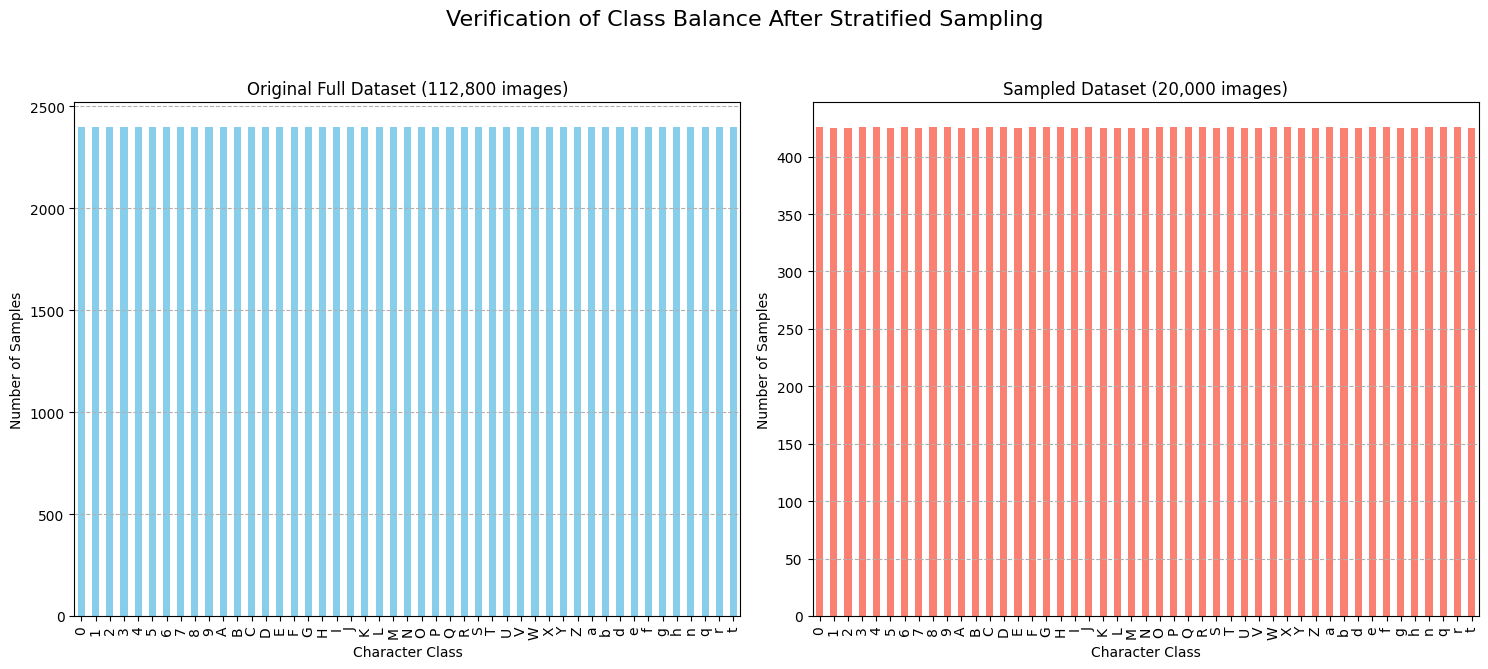

In [ ]:
import pandas as pd

print("Verifying the balance of the sampled training data...")

original_counts = pd.Series(y_train).value_counts()
sampled_counts = pd.Series(y_train_sampled).value_counts()

balance_df = pd.DataFrame({
    'Original Count': original_counts,
    'Sampled Count': sampled_counts
})
balance_df.index = balance_df.index.map(mapping)
balance_df.sort_index(inplace=True)

print("\nComparison of Class Counts (Original vs. Sampled):")
print(balance_df.to_string())

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
balance_df['Original Count'].plot(kind='bar', color='skyblue')
plt.title('Original Full Dataset (112,800 images)')
plt.xlabel('Character Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--')

plt.subplot(1, 2, 2)
balance_df['Sampled Count'].plot(kind='bar', color='salmon')
plt.title('Sampled Dataset (20,000 images)')
plt.xlabel('Character Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--')

plt.suptitle('Verification of Class Balance After Stratified Sampling', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



--- Training Logistic Regression ---

===== Evaluating: Logistic Regression =====
Accuracy:    0.6384
Macro F1:    0.6370
Train Time:  53.07s
Pred Time:   0.14s

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.57      0.55       400
           1       0.46      0.58      0.51       400
           2       0.68      0.65      0.66       400
           3       0.78      0.84      0.81       400
           4       0.59      0.61      0.60       400
           5       0.65      0.60      0.62       400
           6       0.76      0.78      0.77       400
           7       0.85      0.83      0.84       400
           8       0.70      0.65      0.67       400
           9       0.58      0.69      0.63       400
           A       0.67      0.65      0.66       400
           B       0.71      0.65      0.68       400
           C       0.71      0.75      0.73       400
           D       0.68      0.69      0.69       400
   

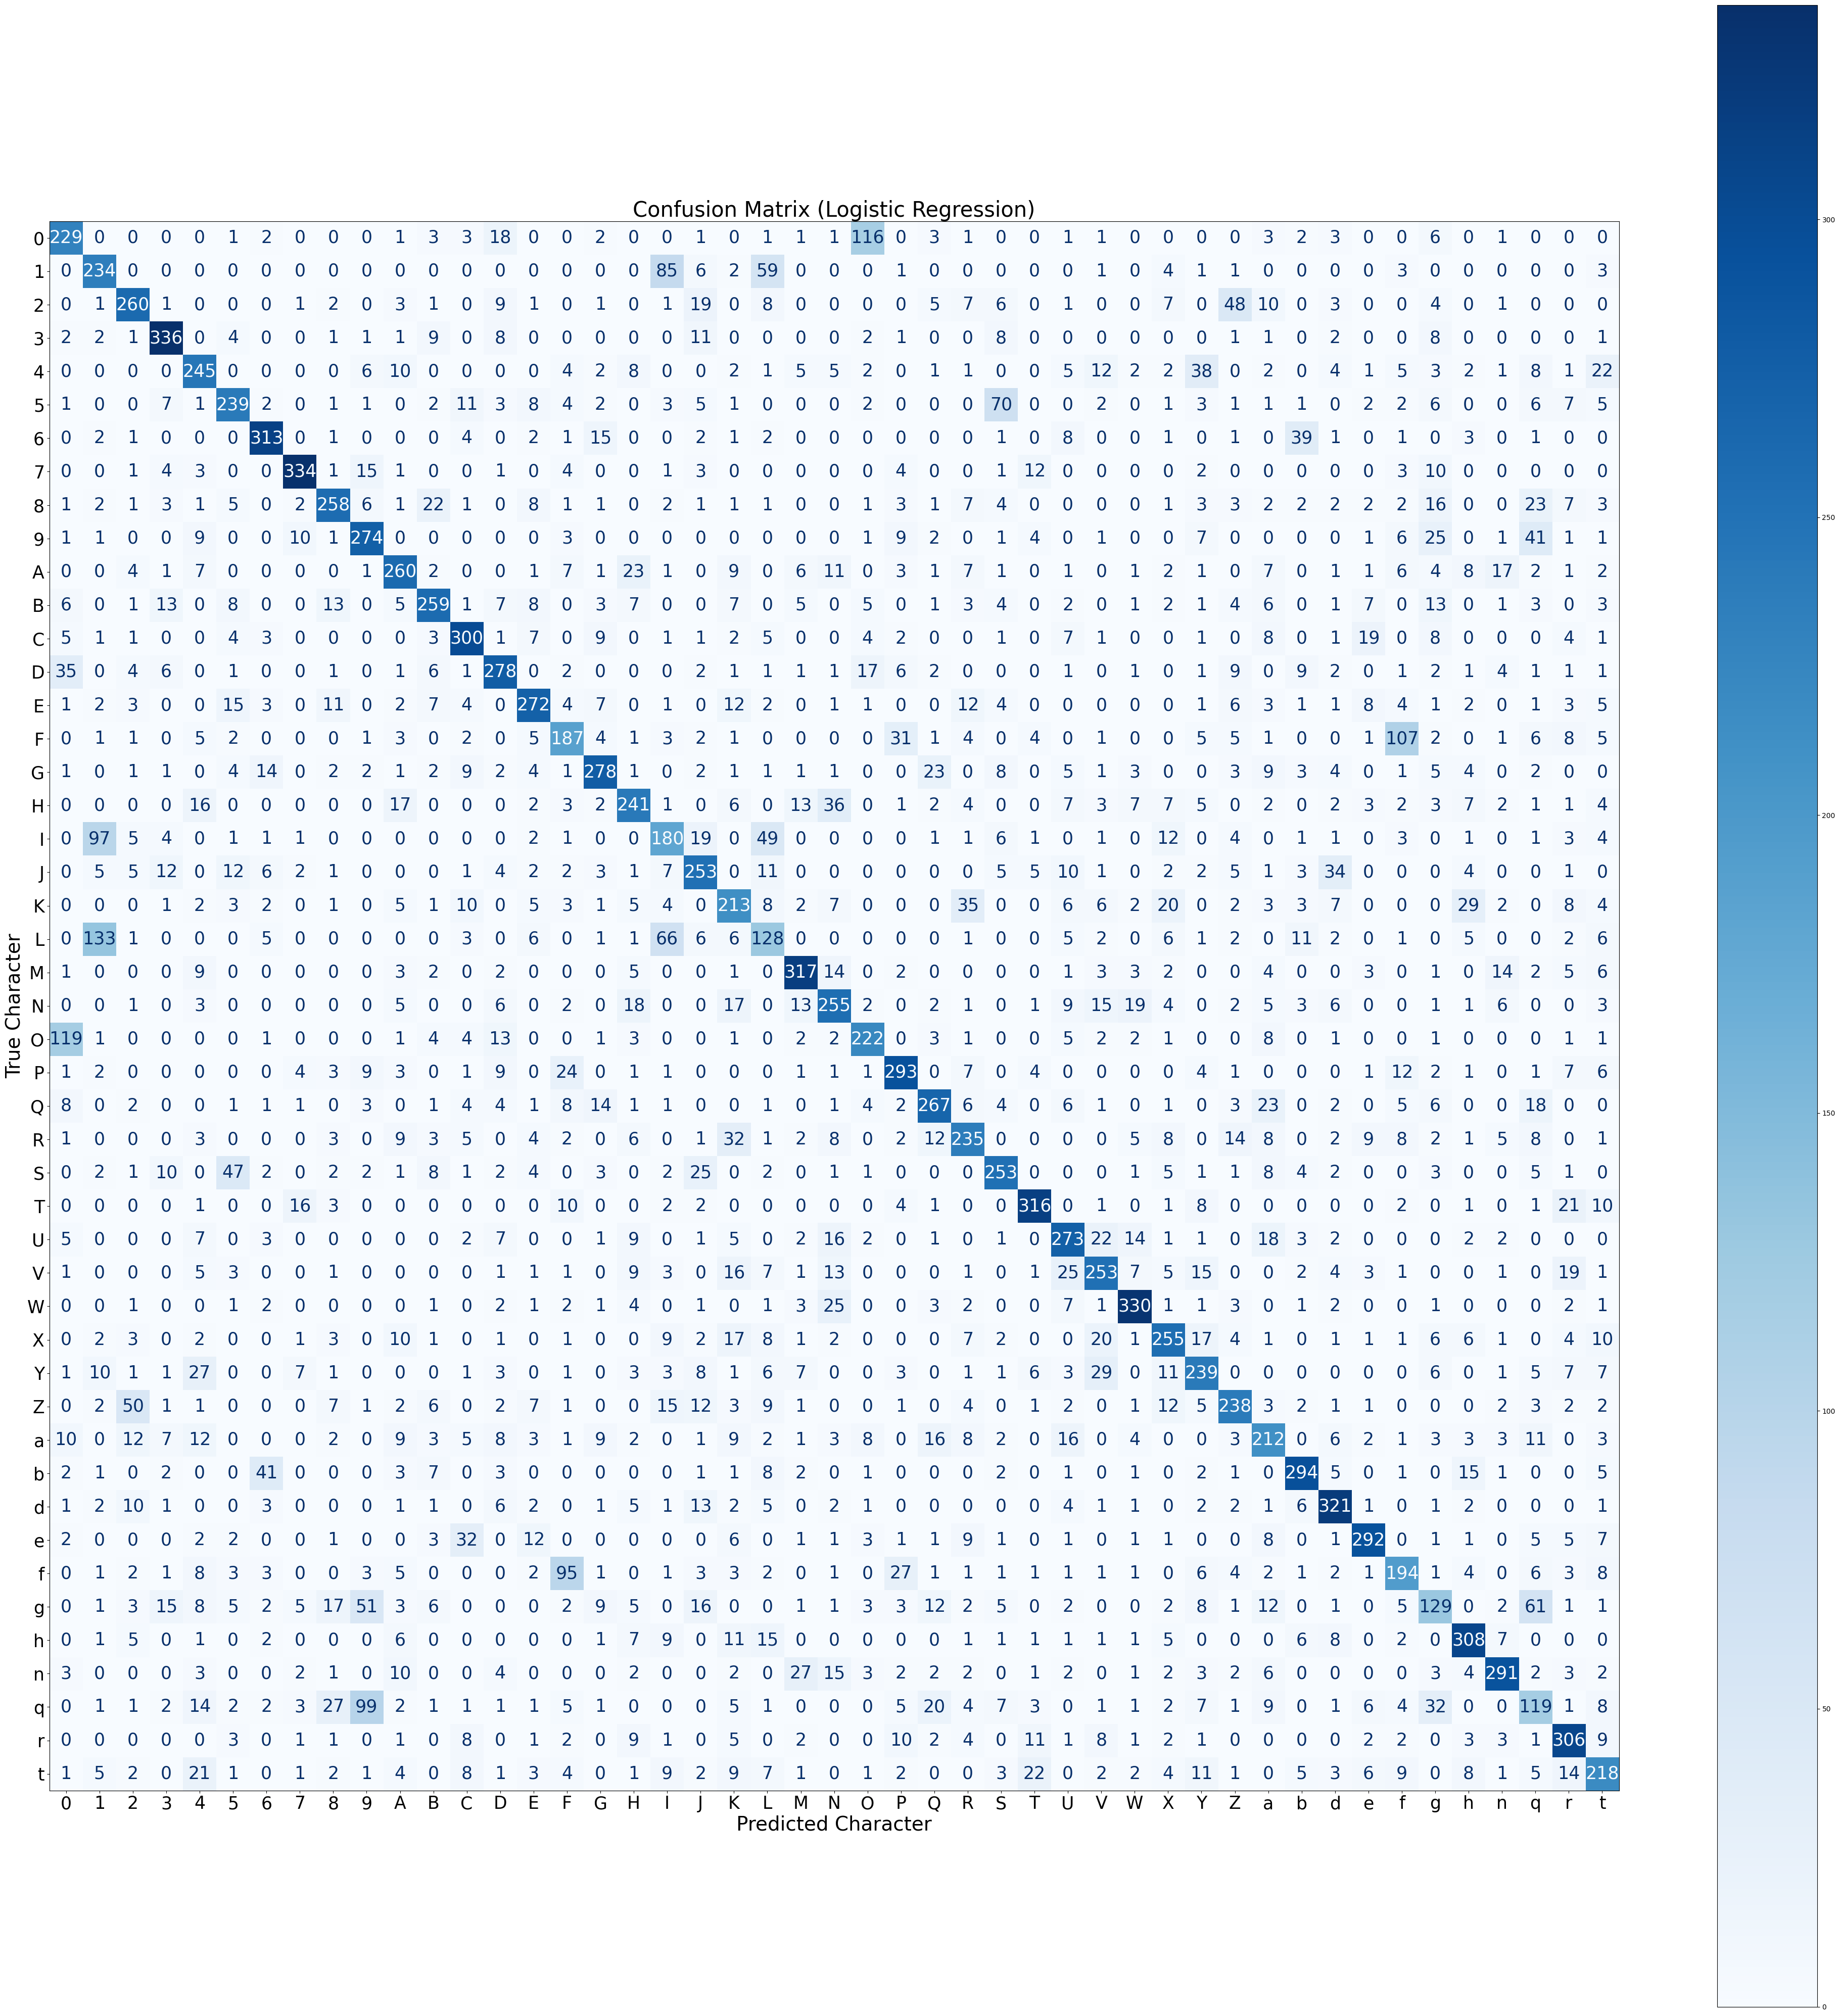

In [ ]:
print("\n--- Training Logistic Regression ---")
model_lr = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42, n_jobs=-1)
start_time = time.time()
model_lr.fit(x_train_flat, y_train_ml)
training_time = time.time() - start_time
evaluate_model(model_lr, x_test_flat, y_test_ml, class_names, training_time, "Logistic Regression")


--- Training Random Forest ---


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.



===== Evaluating: Random Forest =====


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished


Accuracy:    0.7549
Macro F1:    0.7525
Train Time:  23.77s
Pred Time:   0.85s

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.48      0.64      0.55       400
           2       0.82      0.71      0.76       400
           3       0.86      0.90      0.88       400
           4       0.77      0.79      0.78       400
           5       0.82      0.72      0.76       400
           6       0.81      0.84      0.83       400
           7       0.89      0.91      0.90       400
           8       0.72      0.73      0.73       400
           9       0.57      0.78      0.66       400
           A       0.75      0.82      0.78       400
           B       0.77      0.76      0.77       400
           C       0.82      0.86      0.84       400
           D       0.80      0.77      0.79       400
           E       0.87      0.79      0.83       400
           F       0.61      0.4

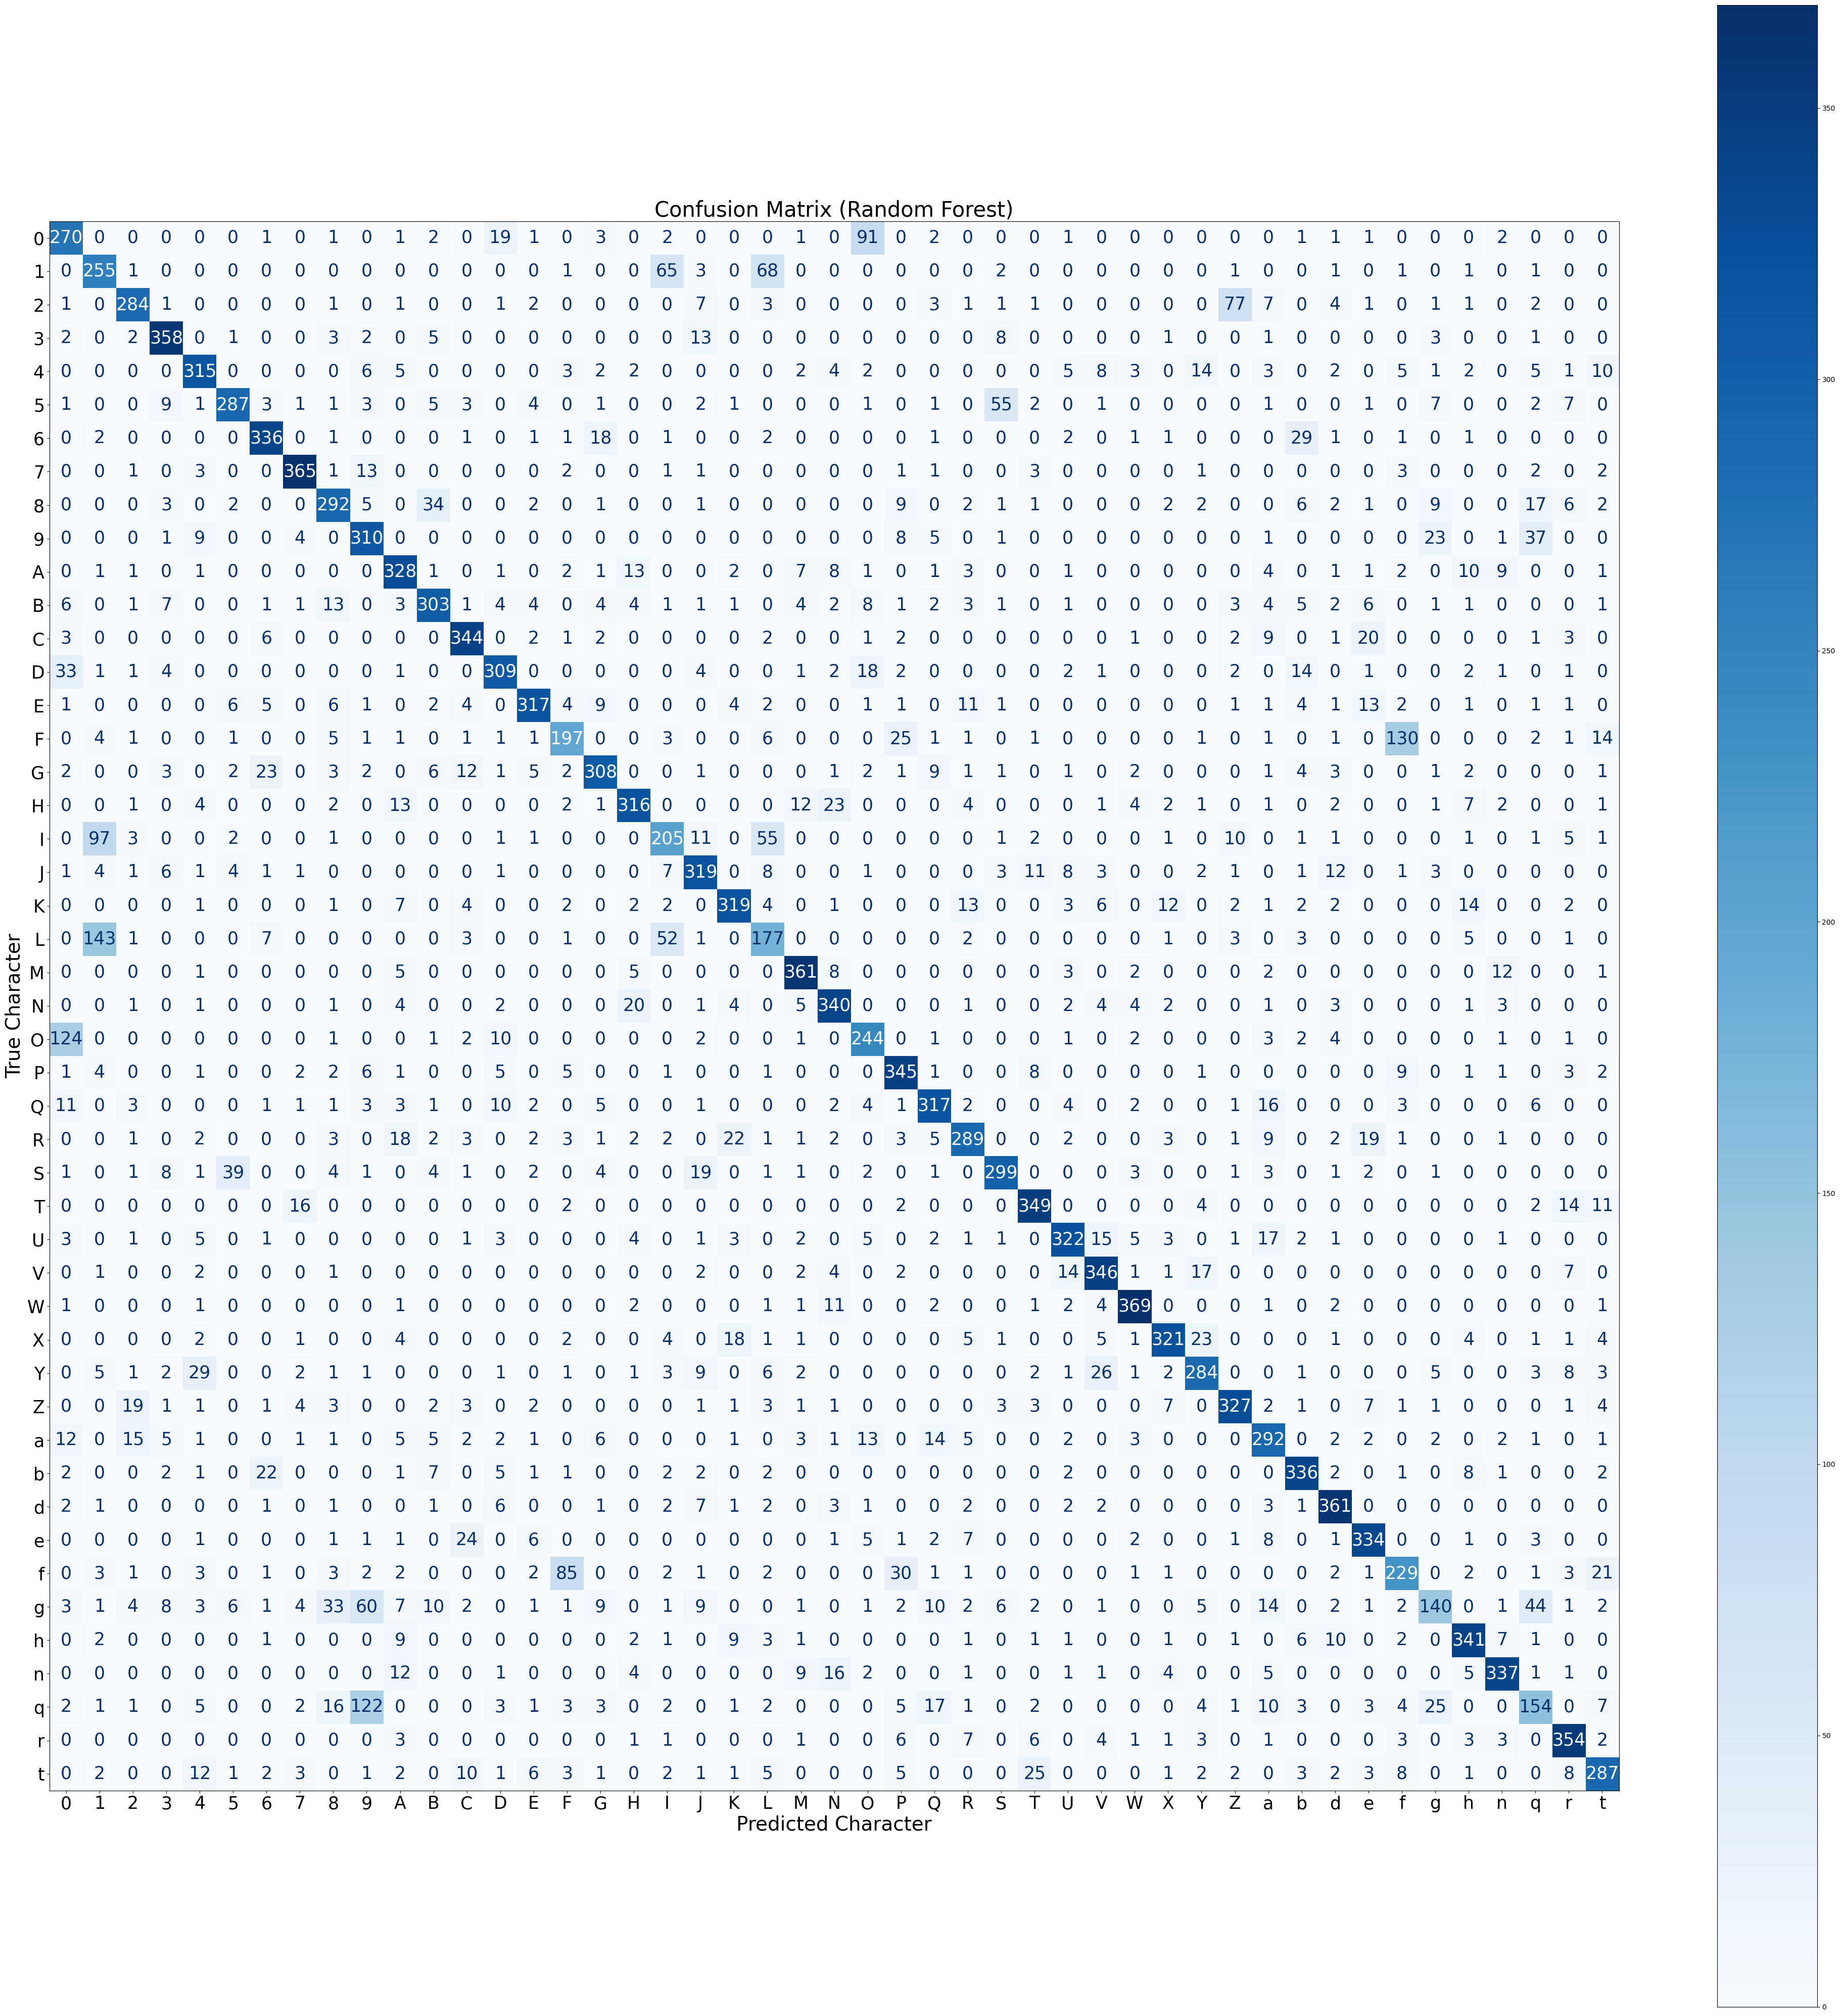

In [ ]:
# 2. Random Forest
print("\n--- Training Random Forest ---")
model_rf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42, n_jobs=-1, verbose=1)
start_time = time.time()
model_rf.fit(x_train_flat, y_train_ml)
training_time = time.time() - start_time
evaluate_model(model_rf, x_test_flat, y_test_ml, class_names, training_time, "Random Forest")


--- Training XGBoost ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:57:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== Evaluating: XGBoost =====
Accuracy:    0.7337
Macro F1:    0.7334
Train Time:  1031.21s
Pred Time:   2.46s

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.63      0.58       400
           1       0.48      0.59      0.53       400
           2       0.78      0.73      0.76       400
           3       0.84      0.85      0.85       400
           4       0.76      0.77      0.77       400
           5       0.80      0.69      0.74       400
           6       0.82      0.81      0.81       400
           7       0.89      0.88      0.88       400
           8       0.74      0.69      0.72       400
           9       0.58      0.67      0.62       400
           A       0.76      0.75      0.76       400
           B       0.76      0.79      0.77       400
           C       0.78      0.82      0.80       400
           D       0.74      0.76      0.75       400
           E       0.86      0.83      0.84       4

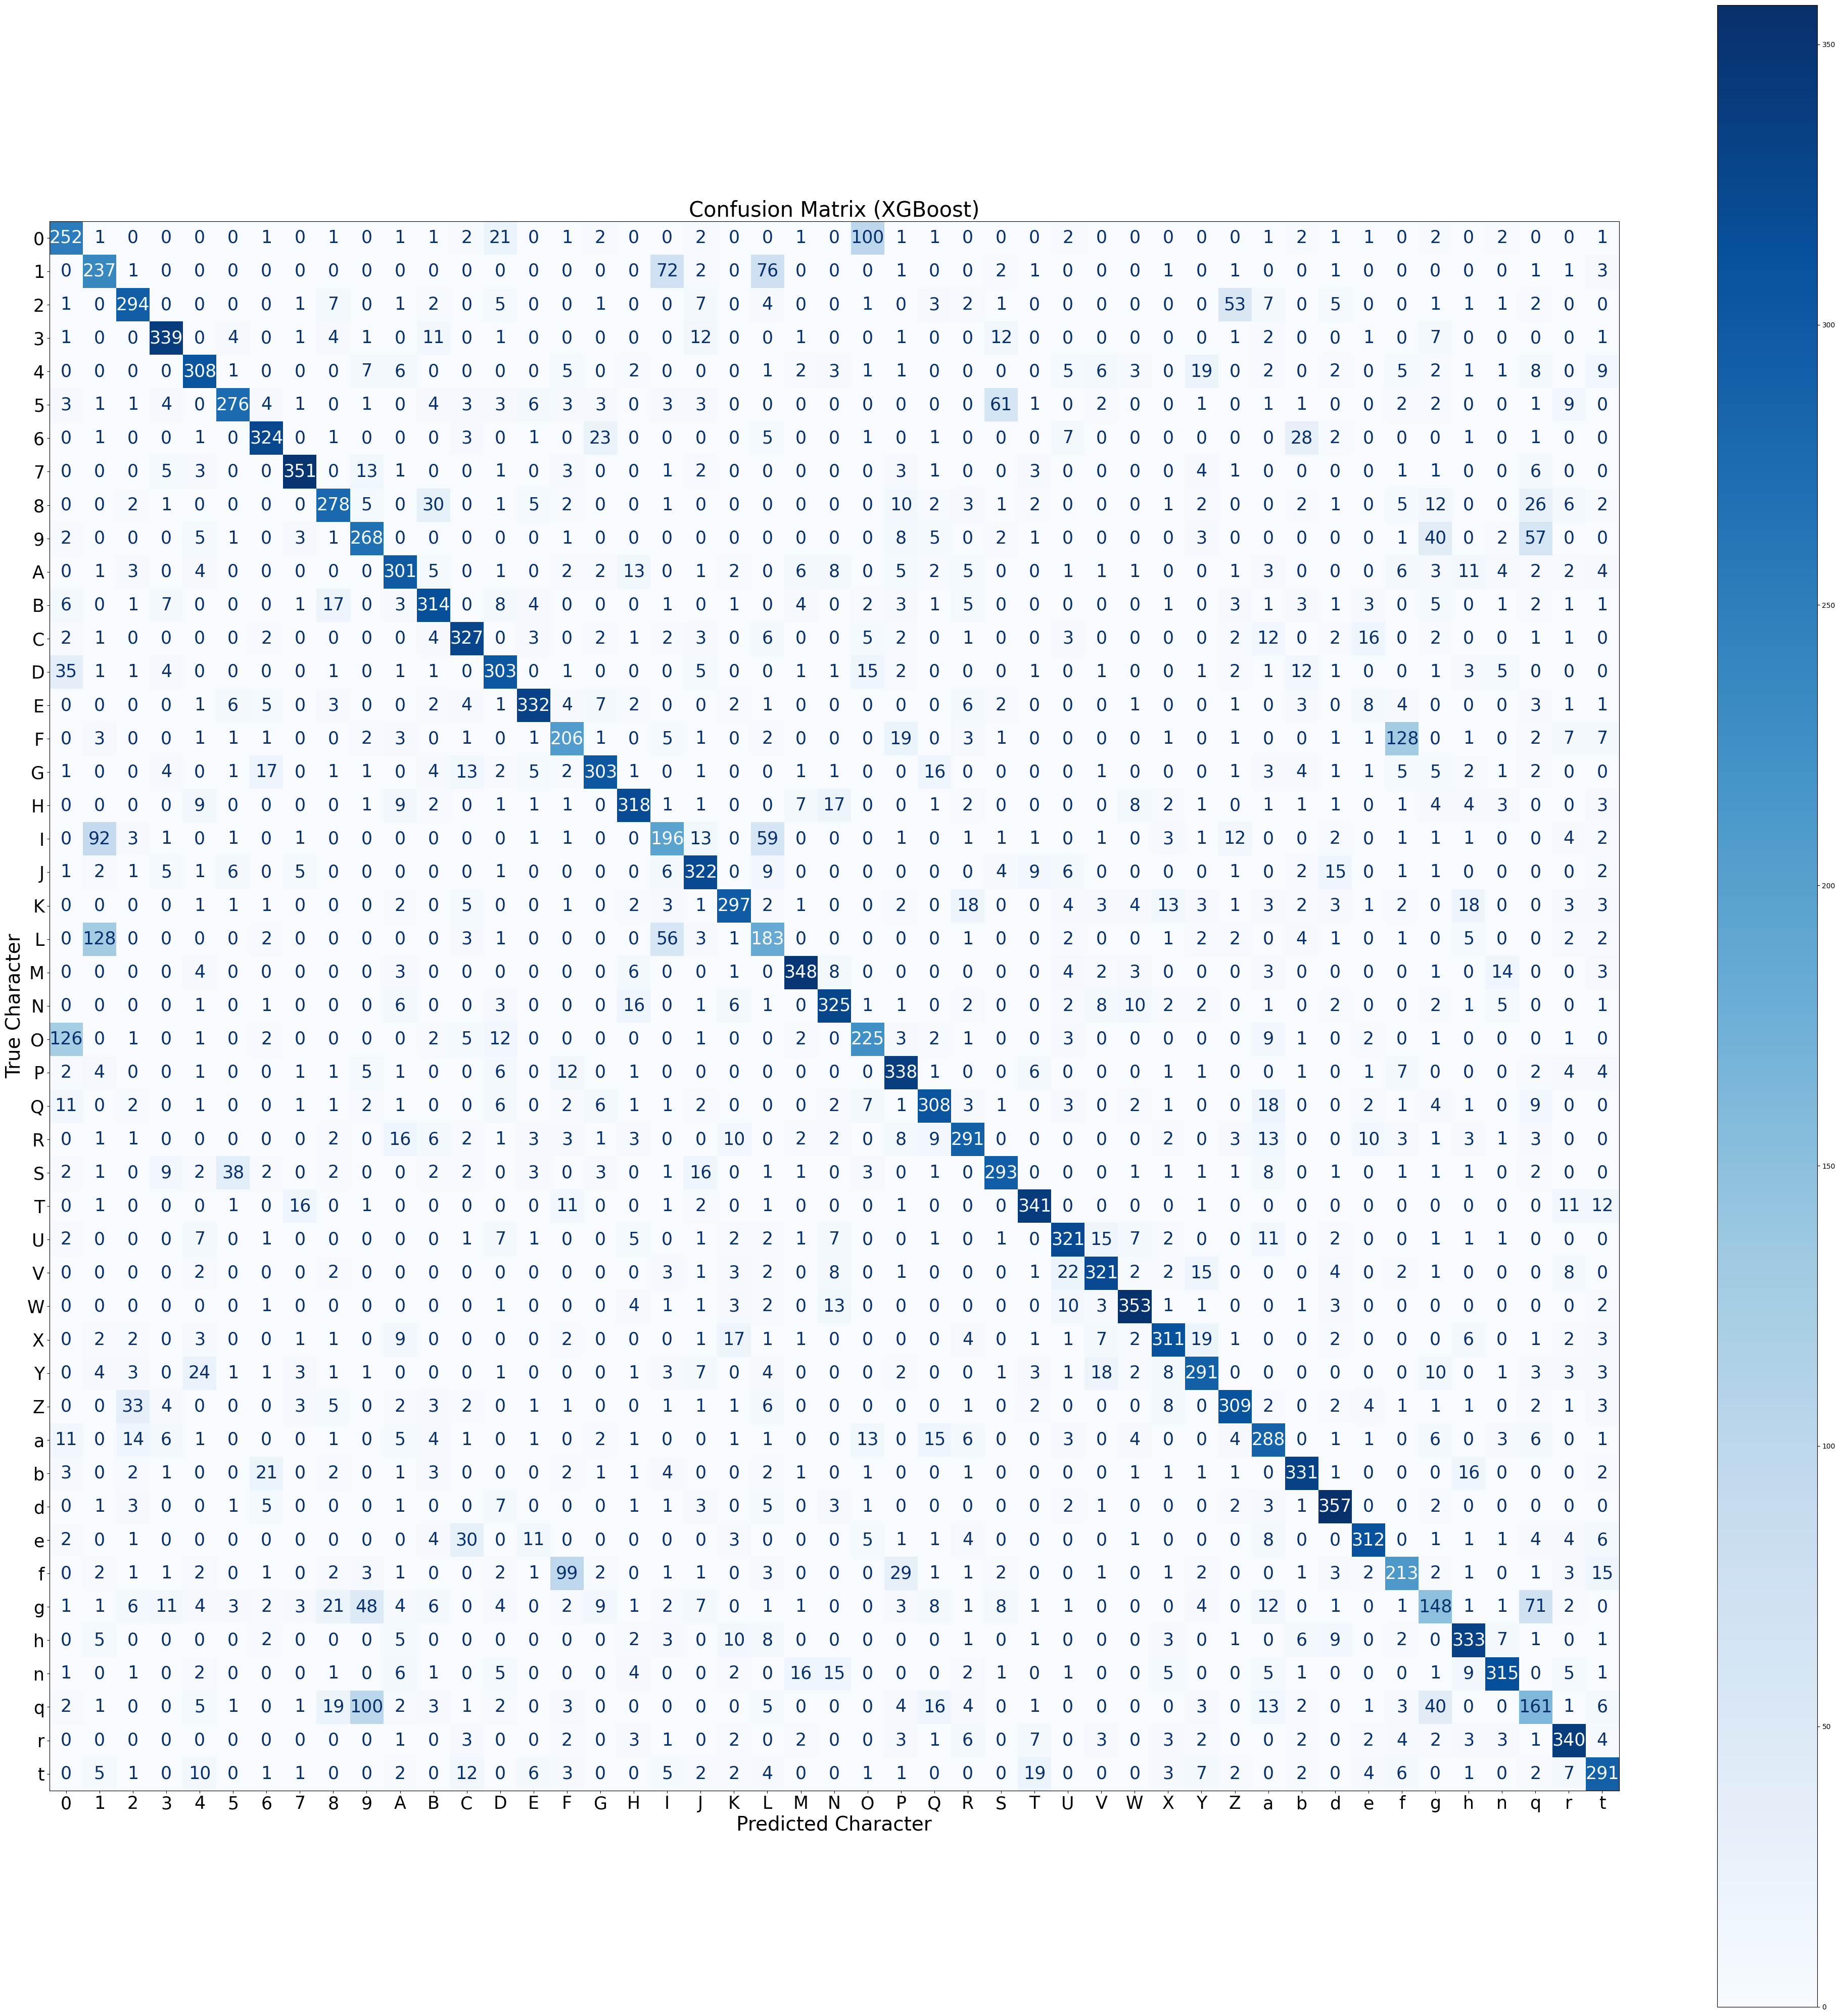

In [ ]:
# 3. XGBoost
print("\n--- Training XGBoost ---")
model_xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
start_time = time.time()
model_xgb.fit(x_train_flat, y_train_ml)
training_time = time.time() - start_time
evaluate_model(model_xgb, x_test_flat, y_test_ml, class_names, training_time, "XGBoost")


--- Training Multi-Layer Perceptron ---
Iteration 1, loss = 2.10377179
Validation score: 0.616500
Iteration 2, loss = 1.18974206
Validation score: 0.665000
Iteration 3, loss = 0.98096947
Validation score: 0.708000
Iteration 4, loss = 0.83870559
Validation score: 0.730500
Iteration 5, loss = 0.73474810
Validation score: 0.732000
Iteration 6, loss = 0.65799041
Validation score: 0.751500
Iteration 7, loss = 0.59820111
Validation score: 0.760500
Iteration 8, loss = 0.53994883
Validation score: 0.766000
Iteration 9, loss = 0.49597579
Validation score: 0.772000
Iteration 10, loss = 0.46149492
Validation score: 0.766000
Iteration 11, loss = 0.42247236
Validation score: 0.773500
Iteration 12, loss = 0.39543964
Validation score: 0.764000
Iteration 13, loss = 0.36626230
Validation score: 0.779500
Iteration 14, loss = 0.33964019
Validation score: 0.785500
Iteration 15, loss = 0.31282272
Validation score: 0.781500
Iteration 16, loss = 0.30449201
Validation score: 0.781500
Iteration 17, loss = 0.2

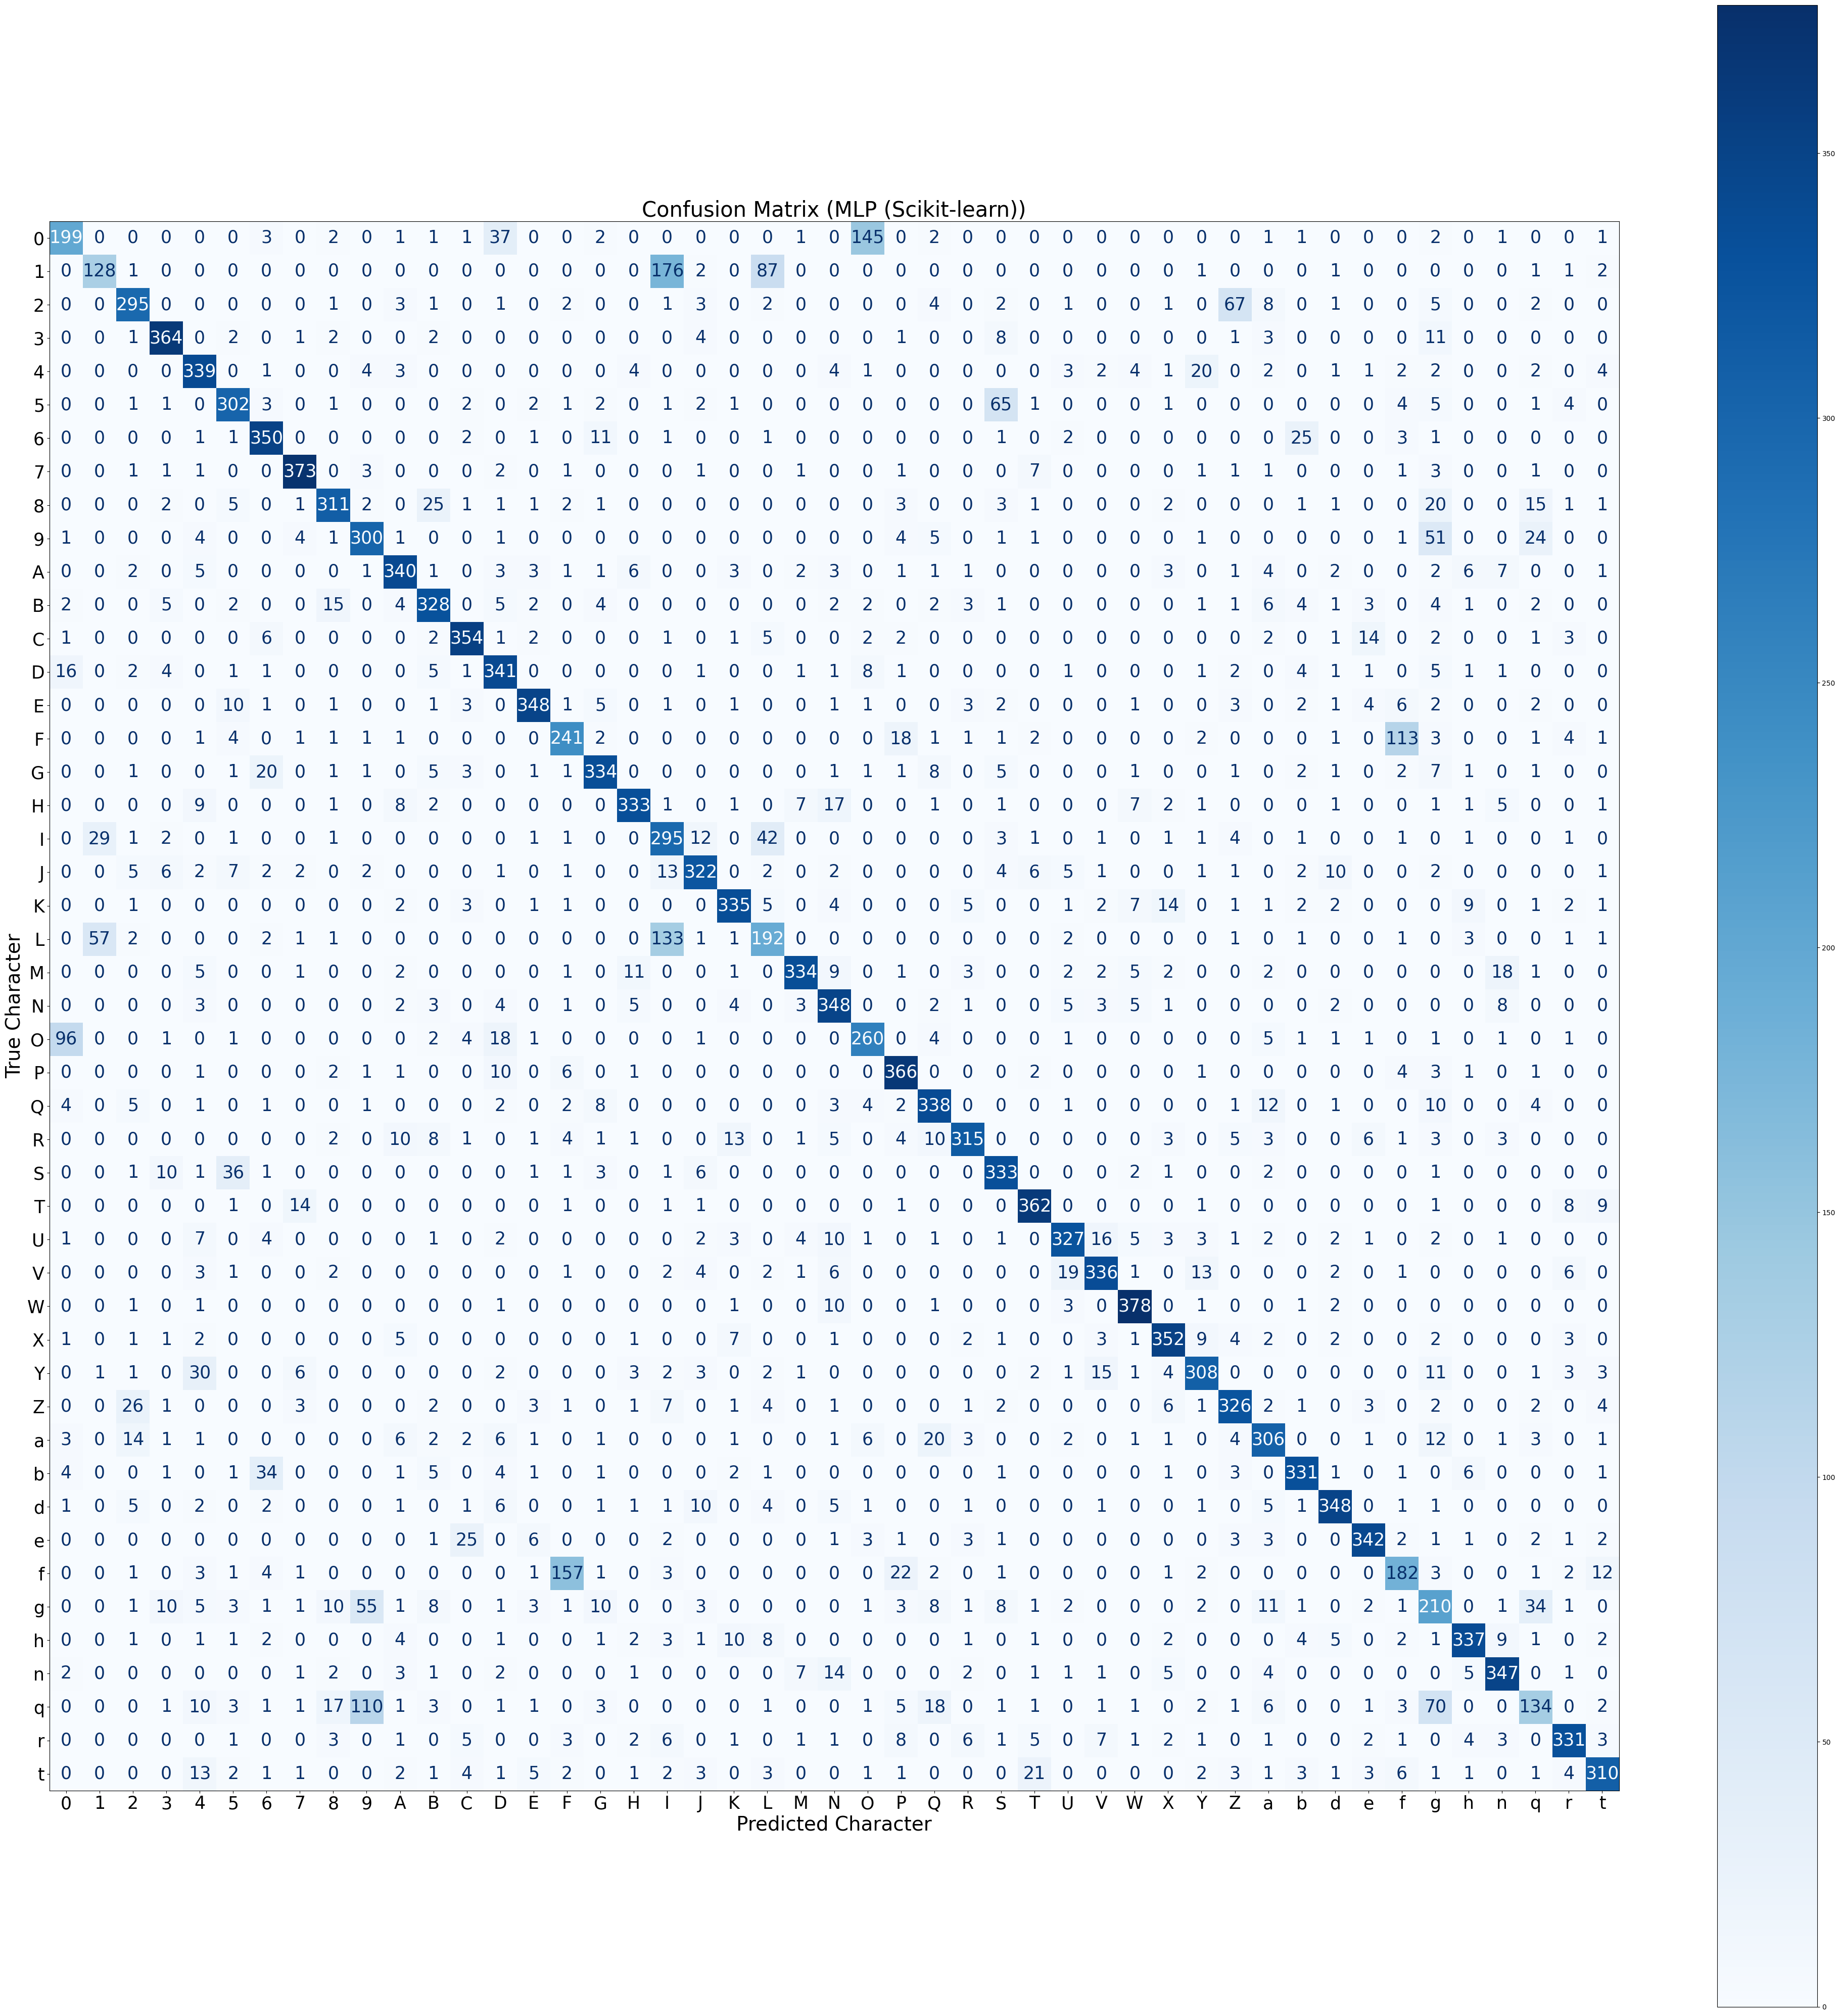

In [ ]:
# 4. Multi-Layer Perceptron (pretty much similar to Neural Networks)
print("\n--- Training Multi-Layer Perceptron ---")
model_mlp = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', solver='adam', max_iter=50,
                          early_stopping=True, n_iter_no_change=5, random_state=42, verbose=True)
start_time = time.time()
model_mlp.fit(x_train_flat, y_train_ml)
training_time = time.time() - start_time
evaluate_model(model_mlp, x_test_flat, y_test_ml, class_names, training_time, "MLP (Scikit-learn)")